# Text Analysis and Visualization Notebook

This notebook processes a CSV file containing text data, cleans the text by removing markdown formatting and URLs, filters out non-Tagalog or Taglish text based on a specified confidence threshold, and visualizes the results. The goal is to identify and analyze Filipino phrases in the dataset.


In [10]:
# Import necessary libraries
import pandas as pd
from lingua import Language, LanguageDetectorBuilder  # Placeholder for actual import if using a different library
from markdown import Markdown
from io import StringIO
import re
import matplotlib.pyplot as plt

## Configuration

Set the path to the CSV file and the threshold for identifying Tagalog content.

In [11]:
# Configuration variables
CSV_FILENAME = input()  # Path to the CSV file
TAGALOG_THRESHOLD = 0.5  # Threshold for Tagalog content detection

# Initialize the language detector with the specified languages
languages = [Language.ENGLISH, Language.TAGALOG]

# Ensure the Tagalog threshold is within the valid range
if not (0.00 <= TAGALOG_THRESHOLD <= 1.00):
    print("ERROR: Tagalog threshold must be between 0.0 and 1.0")
    exit(1)

## Initialization

In [12]:
detector = LanguageDetectorBuilder.from_languages(*languages).build()

## Text Processing Functions

Define functions to clean the text data by removing markdown formatting, URLs, and Reddit usernames.

In [13]:
# Function to convert markdown formatted text to plain text
def unmark_element(element, stream=None):
    if stream is None:
        stream = StringIO()
    if element.text:
        stream.write(element.text)
    for sub in element:
        unmark_element(sub, stream)
    if element.tail:
        stream.write(element.tail)
    return stream.getvalue()

# Patching the Markdown library to add a plain text output format
Markdown.output_formats["plain"] = unmark_element
__md = Markdown(output_format="plain")
__md.stripTopLevelTags = False

# Wrapper function to convert markdown text to plain text
def unmark(text):
    return __md.convert(text)

# Function to remove URLs from a text string and replace them with '[LINK]'
def remove_urls(text):
    url_pattern = re.compile(r'http\S+', re.IGNORECASE)
    return url_pattern.sub('[LINK]', text)

# Function to remove Reddit usernames from a text string and replace them with '[USERNAME]'
def remove_usernames(text):
    username_pattern = re.compile(r"/?u/[A-Za-z0-9_-]+", re.IGNORECASE)
    return username_pattern.sub('[USERNAME]', text)

## Main Data Processing & Saving Processed Data

Read the CSV file, process the text data, filter based on the Tagalog content threshold, and count the number of Filipino phrases identified. Save the filtered and processed data to a new CSV file.


In [14]:
# Read the CSV file
try:
    csv_data = pd.read_csv(CSV_FILENAME, lineterminator='\n')
except FileNotFoundError:
    print("ERROR: File not found")
    exit(1)

csv_data

,submission_name,submission_text,body
0,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,I want to start vlogging and I'm going to use ...
1,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,Hi Po need lang Po nang Help kc Po. May Visa a...
2,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,"NBI HIT\nGot an incident pero suoer tagal, 24 ..."
3,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,Hi! Hope somebody can help me with knowing wha...
4,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,Planning to buy dumbbell and my last lift was ...
...,...,...,...
1133,Nice modern jeep with a more traditional vibe ...,NaN,"Don't you worry, wala naman pinephase out. Han..."
1134,Nice modern jeep with a more traditional vibe ...,NaN,can you elaborate anong proseso dapat ang gawi...
1135,Nice modern jeep with a more traditional vibe ...,NaN,"Sorry, struggling with my Tagalog. No aircon? ..."
1136,Nice modern jeep with a more traditional vibe ...,NaN,"Oh geez, di naman sinabi na walang ilalabas na..."


## Count Before Filtering
Start by capturing the count of rows in your DataFrame before applying any filters:

In [15]:
# Count the number of rows before filtering
count_before_filtering = len(csv_data)

print(f"Count before filtering: {count_before_filtering}")

Count before filtering: 1138


In [17]:
# Add a blank 'label' column for annotation
csv_data['label'] = ''

csv_data

,submission_name,submission_text,body,label
0,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,I want to start vlogging and I'm going to use ...,
1,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,Hi Po need lang Po nang Help kc Po. May Visa a...,
2,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,"NBI HIT\nGot an incident pero suoer tagal, 24 ...",
3,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,Hi! Hope somebody can help me with knowing wha...,
4,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,Planning to buy dumbbell and my last lift was ...,
...,...,...,...,...
1133,Nice modern jeep with a more traditional vibe ...,NaN,"Don't you worry, wala naman pinephase out. Han...",
1134,Nice modern jeep with a more traditional vibe ...,NaN,can you elaborate anong proseso dapat ang gawi...,
1135,Nice modern jeep with a more traditional vibe ...,NaN,"Sorry, struggling with my Tagalog. No aircon? ...",
1136,Nice modern jeep with a more traditional vibe ...,NaN,"Oh geez, di naman sinabi na walang ilalabas na...",


In [18]:
from tqdm.auto import tqdm # Import tqdm for fancy progress bars

filipino_phrases = 0  # Counter for Filipino phrases

In [19]:
for row in tqdm(csv_data.itertuples(), total=count_before_filtering, desc="LINES"):  # Iterate over each row in the CSV
    text = str(row.body)  # Convert to string to handle non-string data

    # Clean the text by removing markdown, URLs, & usernames
    text = unmark(text)
    text = remove_urls(text)
    text = remove_usernames(text)

    # Compute the confidence of the text being Tagalog
    result = detector.compute_language_confidence(text, Language.TAGALOG)
    
    # If the confidence is above the threshold, consider it a Filipino phrase
    if result >= TAGALOG_THRESHOLD:
        filipino_phrases += 1
        csv_data.at[row.Index, 'body'] = text  # Update the text in the CSV
    else:
        csv_data.drop(row.Index, inplace=True)  # Drop rows that don't meet the threshold

print("Finished cleaning and filtering")

LINES: 100%|██████████| 1138/1138 [00:05<00:00, 210.55it/s]

Finished cleaning and filtering


In [20]:
print(f"Total: {filipino_phrases} / {count_before_filtering}")  # Print the total number of Filipino phrases found

Total: 523 / 1138


In [21]:
# Save the filtered CSV
filtered_filename = CSV_FILENAME.replace('.csv', '-filtered.csv')
csv_data.to_csv(filtered_filename, index=False)  # Prevent index from being saved as a column

print(f"Filtered data saved to {filtered_filename}")

Filtered data saved to testing-filtered.csv


## Visualization of Filtering Effect

To understand the impact of our filtering based on the Tagalog content threshold, we will visualize the number of comments in the dataset before and after the filtering process. This will help us gauge the extent of data reduction and ensure that the filtering aligns with our expectations.

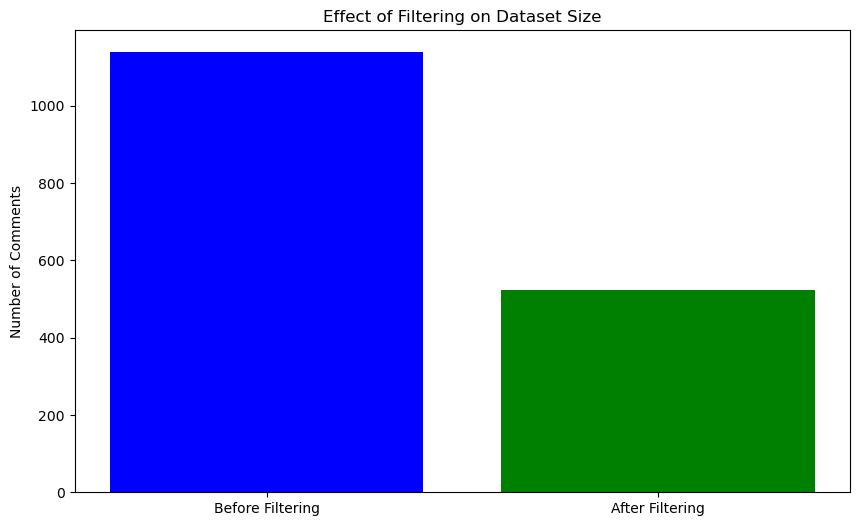

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(['Before Filtering', 'After Filtering'], [count_before_filtering, filipino_phrases], color=['blue', 'green'])
plt.title('Effect of Filtering on Dataset Size')
plt.ylabel('Number of Comments')
plt.show()